##  Job Search with Learning

#### John Stachurski

Fall semester 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lininterp import interp1d
from numba import njit, vectorize, prange
from interpolation import interp
from math import gamma
from scipy.stats import beta

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Let's set up some fast jitted functions that implement beta distributions.  In doing so we recall that the beta density is

$$ 
    p(x, a, b) = \frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)}
        x^{a-1} (1 - x)^{b-1}
        \qquad (0 \leq x \leq 1)
$$


In [3]:
def beta_function_factory(a, b):
    
    @vectorize
    def p(x):
        r = gamma(a + b) / (gamma(a) * gamma(b))
        return r * x**(a-1) * (1 - x)**(b-1)
    
    return p

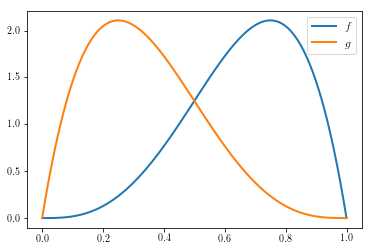

In [11]:
x_grid = np.linspace(0, 1, 100)
f = beta_function_factory(4, 2)
g = beta_function_factory(2, 4)

plt.plot(x_grid, f(x_grid), label='$f$', lw=2)
plt.plot(x_grid, g(x_grid), label='$g$', lw=2)

plt.legend(fontsize=12)
plt.show()

A convex combination

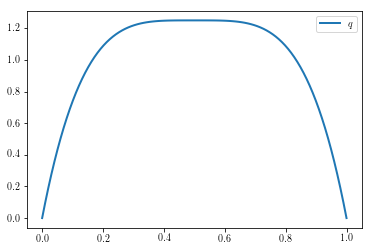

In [48]:
plt.plot(x_grid, 0.5 * f(x_grid) + 0.5 * g(x_grid), 
         label='$q$', lw=2)
plt.legend()
plt.show()

In [5]:
class SearchProblem:

    def __init__(self, 
                 β=0.95, 
                 c=0.1, 
                 F_a=4, 
                 F_b=2, 
                 G_a=2, 
                 G_b=4,
                 π_grid_size=20,
                 mc_size=10000):

        self.β, self.c = β, c
        
        self.π_grid = np.linspace(0, 1, π_grid_size)
        
        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)
        
        self.f = beta_function_factory(F_a, F_b)
        self.g = beta_function_factory(G_a, G_b)
        
        self.mc_size = mc_size

In [6]:
def Q_factory(sp, seed=123):

    # == Simplify names == #
    β, c, π_grid = sp.β, sp.c, sp.π_grid
    w_f, w_g = sp.w_f, sp.w_g
    f, g = sp.f, sp.g
    mc_size = sp.mc_size

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        new_π =  pf / (pf + pg)
        return new_π
    
    @njit
    def Q(ω):
                    
        # == Turn ω into a function == #
        def ω_func(x):
            return interp(π_grid, ω, x)
        
        new_ω = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]

            # Evaluate expectation
            integral_f, integral_g = 0.0, 0.0
            for m in range(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π)))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π)))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            # Update Qω
            new_ω[i] = (1 - β) * c + β * integral

        return new_ω
    
    return Q

In [7]:

def Q_iterator(sp, max_iter=500, tol=1e-4):
    
    ω_init = np.ones(len(sp.π_grid))
    Q = Q_factory(sp)
    ω = ω_init
    ϵ = tol + 1
    i = 0
    
    while i < max_iter and ϵ > tol:
        new_ω = Q(ω)
        ϵ = np.max(np.abs(ω - new_ω))
        ω = new_ω
        i += 1
        
    if i == max_iter:
        print("Warning: hit maximum iterations")
        
        
    return ω

In [8]:
sp1 = SearchProblem()


In [10]:
%%time
ω_1 = Q_iterator(sp1)

CPU times: user 1.75 s, sys: 9.65 ms, total: 1.76 s
Wall time: 1.76 s


In [25]:
sp2 = SearchProblem(c=0.2)
ω_2 = Q_iterator(sp2)

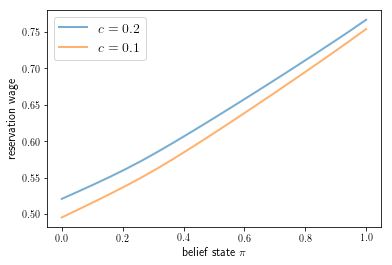

In [26]:
fig, ax = plt.subplots()

ax.plot(sp2.π_grid, ω_2, lw=2, alpha=0.6, label='$c = 0.2$')
ax.plot(sp1.π_grid, ω_1, lw=2, alpha=0.6, label='$c = 0.1$')

ax.legend(fontsize=14)
ax.set_xlabel("belief state $\\pi$", fontsize=12)
ax.set_ylabel("reservation wage", fontsize=12)
plt.show()